In [28]:
import numpy as np
import pandas as pd
import scipy
from statsmodels.stats.weightstats import *

In [7]:
raw = pd.read_csv("gene_high_throughput_sequencing.txt", sep=",");

Практическая значимость изменения
Цель исследований — найти гены, средняя экспрессия которых отличается не только статистически значимо, но и достаточно сильно. В экспрессионных исследованиях для этого часто используется метрика, которая называется fold change (кратность изменения). Определяется она следующим образом:

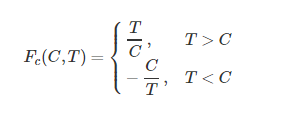

где C,T — средние значения экспрессии гена в control и treatment группах соответственно. По сути, fold change показывает, во сколько раз отличаются средние двух выборок.

Инструкции к решению задачи
Задание состоит из трёх частей. Если не сказано обратное, то уровень значимости нужно принять равным 0.05.

Часть 1: применение t-критерия Стьюдента
В первой части вам нужно будет применить критерий Стьюдента для проверки гипотезы о равенстве средних в двух независимых выборках. Применить критерий для каждого гена нужно будет дважды:

для групп normal (control) и early neoplasia (treatment)
для групп early neoplasia (control) и cancer (treatment)
В качестве ответа в этой части задания необходимо указать количество статистически значимых отличий, которые вы нашли с помощью t-критерия Стьюдента, то есть число генов, у которых p-value этого теста оказался меньше, чем уровень значимости.

In [20]:
def FoldChange(array1, array2):
    mean1 = np.mean(array1)
    mean2 = np.mean(array2)
    if (mean1>mean2):
        return mean1/mean2
    else:
        return -mean2/mean1

In [38]:
print np.unique(raw.Diagnosis.values)
#'cancer', 'early neoplasia', 'normal'
normalPatiens = raw[raw.Diagnosis == "normal"]
cancerPatiens = raw[raw.Diagnosis == "cancer"]
earlyNeoplasiaPatiens = raw[raw.Diagnosis == "early neoplasia"]
studentProbability = pd.DataFrame()
counter1 = 0
counter2 = 0
for columnName in raw.columns[2:]:
    pNeoplasia = scipy.stats.ttest_ind(normalPatiens[columnName], earlyNeoplasiaPatiens[columnName], equal_var = False).pvalue
    pCancer = scipy.stats.ttest_ind(earlyNeoplasiaPatiens[columnName], cancerPatiens[columnName], equal_var = False).pvalue
    studentProbability[columnName] = [pNeoplasia, pCancer]
    if pNeoplasia < 0.05:
        counter1 +=1
    if pCancer < 0.05:
        counter2 +=1
studentProbability.head(5)

print counter1, counter2

['cancer' 'early neoplasia' 'normal']
1575 3490


In [39]:
studentProbability.head(5)

,LOC643837,LOC100130417,SAMD11,NOC2L,KLHL17,PLEKHN1,C1orf170,HES4,ISG15,AGRN,...,CLIC2,RPS4Y1,ZFY,PRKY,USP9Y,DDX3Y,CD24,CYorf15B,KDM5D,EIF1AY
0,0.690766,0.000032,0.060273,0.826429,0.049876,0.144267,0.329108,0.023712,0.240148,0.037933,...,0.463274,0.806008,0.424543,0.740591,0.414922,0.640904,0.830134,0.670395,0.793925,0.661031
1,0.413735,0.653429,0.079556,0.287581,0.463292,0.007681,0.481306,0.578830,0.000740,0.712687,...,0.107366,0.458907,0.893433,0.467608,0.881584,0.659369,0.330617,0.542939,0.565753,0.639010


Часть 2: поправка методом Холма

Для этой части задания вам понадобится модуль multitest из statsmodels.



В этой части задания нужно будет применить поправку Холма для получившихся двух наборов достигаемых уровней значимости из предыдущей части. Обратите внимание, что поскольку вы будете делать поправку для каждого из двух наборов p-value отдельно, то проблема, связанная с множественной проверкой останется.

Для того, чтобы ее устранить, достаточно воспользоваться поправкой Бонферрони, то есть использовать уровень значимости 0.05 / 2 вместо 0.05 для дальнейшего уточнения значений p-value c помощью метода Холма.

В качестве ответа к этому заданию требуется ввести количество значимых отличий в каждой группе после того, как произведена коррекция Холма-Бонферрони. Причем это число нужно ввести с учетом практической значимости: посчитайте для каждого значимого изменения fold change и выпишите в ответ число таких значимых изменений, абсолютное значение fold change которых больше, чем 1.5.

Обратите внимание, что

применять поправку на множественную проверку нужно ко всем значениям достигаемых уровней значимости, а не только для тех, которые меньше значения уровня доверия.
при использовании поправки на уровне значимости 0.025 меняются значения достигаемого уровня значимости, но не меняется значение уровня доверия (то есть для отбора значимых изменений скорректированные значения уровня значимости нужно сравнивать с порогом 0.025, а не 0.05)!

In [40]:
from statsmodels.sandbox.stats.multicomp import multipletests 

In [61]:
reject, p_corrected, a1, a2 = multipletests(studentProbability.loc[0], 
                                            alpha = 0.025, 
                                            method = 'holm') 

counter2_1 = 0
for column in studentProbability.columns[reject]:
    if abs(FoldChange(normalPatiens[column].values, earlyNeoplasiaPatiens[column].values))>1.5:
        counter2_1 +=1
print counter2_1

array([ 1.        ,  0.50017368,  1.        , ...,  1.        ,
        1.        ,  1.        ])

In [84]:
reject, p_corrected, a1, a2 = multipletests(studentProbability.loc[1], 
                                            alpha = 0.025, 
                                            method = 'holm') 

counter2_2 = 0
for column in studentProbability.columns[reject]:
    if abs(FoldChange(earlyNeoplasiaPatiens[column].values, cancerPatiens[column].values))>1.5:
        counter2_2 +=1
print counter2_2

77


Часть 3: поправка методом Бенджамини-Хохберга
Данная часть задания аналогична второй части за исключением того, что нужно будет использовать метод Бенджамини-Хохберга.

Обратите внимание, что методы коррекции, которые контролируют FDR, допускает больше ошибок первого рода и имеют большую мощность, чем методы, контролирующие FWER. Большая мощность означает, что эти методы будут совершать меньше ошибок второго рода (то есть будут лучше улавливать отклонения от H0, когда они есть, и будут чаще отклонять H0, когда отличий нет).

В качестве ответа к этому заданию требуется ввести количество значимых отличий в каждой группе после того, как произведена коррекция Бенджамини-Хохберга, причем так же, как и во второй части, считать только такие отличия, у которых abs(fold change) > 1.5.

In [85]:
reject, p_corrected, a1, a2 = multipletests(studentProbability.loc[0], 
                                            alpha = 0.025, 
                                            method = 'fdr_bh') 

counter3_1 = 0
for column in studentProbability.columns[reject]:
    if abs(FoldChange(normalPatiens[column].values, earlyNeoplasiaPatiens[column].values))>1.5:
        counter3_1 +=1

reject, p_corrected, a1, a2 = multipletests(studentProbability.loc[1], 
                                            alpha = 0.025, 
                                            method = 'fdr_bh') 

counter3_2 = 0
for column in studentProbability.columns[reject]:
    if abs(FoldChange(earlyNeoplasiaPatiens[column].values, cancerPatiens[column].values))>1.5:
        counter3_2 +=1
print counter3_1, counter3_2

4 524
